In [3]:
import sys
# !{sys.executable} -m spacy download en
import re, numpy as np, pandas as pd
from pprint import pprint

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])

%matplotlib inline
warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

In [8]:
!pip install -U gensim

  Using cached gensim-3.8.3-cp37-cp37m-win_amd64.whl (24.2 MB)
Processing c:\users\pjjay\appdata\local\pip\cache\wheels\56\b5\6d\86dbe4f29d4688e5163a8b8c6b740494310040286fca4dc648\smart_open-2.1.0-py3-none-any.whl
  Using cached Cython-0.29.14-cp37-cp37m-win_amd64.whl (1.7 MB)
  Using cached boto3-1.14.14-py2.py3-none-any.whl (128 kB)
  Using cached s3transfer-0.3.3-py2.py3-none-any.whl (69 kB)
  Using cached botocore-1.17.14-py2.py3-none-any.whl (6.3 MB)
  Using cached docutils-0.15.2-py3-none-any.whl (547 kB)
  Attempting uninstall: docutils
    Found existing installation: docutils 0.16
    Uninstalling docutils-0.16:
      Successfully uninstalled docutils-0.16
  Attempting uninstall: Cython
    Found existing installation: Cython 0.29.15
    Uninstalling Cython-0.29.15:
      Successfully uninstalled Cython-0.29.15


In [35]:
!pip install -U pyLDAVis

  Created wheel for pyLDAVis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97716 sha256=97f4c585d4b83f90f7f1e5f39ddbb29f6123f7dea261318dfbe1e14117b11f2a
  Stored in directory: c:\users\pjjay\appdata\local\pip\cache\wheels\3b\fb\41\e32e5312da9f440d34c4eff0d2207b46dc9332a7b931ef1e89
  Created wheel for funcy: filename=funcy-1.14-py2.py3-none-any.whl size=32045 sha256=184e04156bc3a08c8f32e8665abc89f45c4a94f72512d403dfbcf002344a25eb
  Stored in directory: c:\users\pjjay\appdata\local\pip\cache\wheels\3c\33\97\805b282e129f60bb4e87cea622338f30b65f21eaf65219971f
Successfully built pyLDAVis funcy


In [24]:
!pip install -U wordcloud

In [4]:
import gensim

In [5]:
# Import Dataset
#df = pd.read_json('https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json')
#df = df.loc[df.target_names.isin(['soc.religion.christian', 'rec.sport.hockey', 'talk.politics.mideast', 'rec.motorcycles']) , :]

df=pd.read_csv('C:/Users/pjjay/Documents/MLCourse/JoeBidenTweets.csv')

print(df.shape)  #> (2361, 3)
df.head()

(4671, 7)


,id,username,timestamp,link,tweet,retweets,likes
0,1277743650412408839,JoeBiden,2020-06-30 04:50,https://twitter.com/JoeBiden/status/1277743650...,"Folks, tomorrow night marks our first end-of-q...",2997,9187
1,1277715968614035457,JoeBiden,2020-06-30 03:00,https://twitter.com/JoeBiden/status/1277715968...,The President spent his weekend golfing.pic.tw...,36516,152042
2,1277703163429208068,JoeBiden,2020-06-30 02:09,https://twitter.com/JoeBiden/status/1277703163...,Here’s my promise to you: I’ll appoint a direc...,8496,40007
3,1277695835413925888,JoeBiden,2020-06-30 01:40,https://twitter.com/JoeBiden/status/1277695835...,Today's decision reaffirmed that states can't ...,5519,25589
4,1277658086556209155,JoeBiden,2020-06-29 23:10,https://twitter.com/JoeBiden/status/1277658086...,It's time we remember who we are as Americans:...,21022,102657


 ## Tokenize Sentences and Clean

In [14]:
# Convert to list
data = df.tweet.values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])

['Folks, tomorrow night marks our first end-of-quarter deadline of the general '
 'election. We need your help to hit our goal so we can catch up to Donald '
 'Trumps hefty cash-on-hand advantage. I know times are tough, but if youre '
 'able, please chip in '
 'today:https://secure.actblue.com/donate/biden2020_fr_q22020-social14?refcode=social-tw-20200629eoq1&utm_medium=social&utm_source=tw&utm_campaign=20200629eoq1 '
 '…']


## Tokenize and Clean up using Gensim process

In [15]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['folks', 'tomorrow', 'night', 'marks', 'our', 'first', 'end', 'of', 'quarter', 'deadline', 'of', 'the', 'general', 'election', 'we', 'need', 'your', 'help', 'to', 'hit', 'our', 'goal', 'so', 'we', 'can', 'catch', 'up', 'to', 'donald', 'trumps', 'hefty', 'cash', 'on', 'hand', 'advantage', 'know', 'times', 'are', 'tough', 'but', 'if', 'youre', 'able', 'please', 'chip', 'in', 'today', 'https', 'secure', 'actblue', 'com', 'donate', 'biden', 'social', 'refcode', 'social', 'tw', 'eoq', 'utm_medium', 'social', 'utm_source', 'tw', 'utm_campaign', 'eoq']]


## Lemmatization

In [17]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# Run in terminal: python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only Noun, Adj, Verb, Adverb
data_lemmatized = lemmatization(data_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:2])

['folk tomorrow night mark first end quarter deadline general election need help hit goal can catch hefty cash hand advantage know time tough be able chip today https secure com donate social eoq', 'spend weekend golf pic twitter com lup']


## Create the document word matrix

In [18]:
vectorizer = CountVectorizer(analyzer='word',       
                             min_df=10,                        # minimum reqd occurences of a word 
                             stop_words='english',             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             # max_features=50000,             # max number of uniq words
                            )

data_vectorized = vectorizer.fit_transform(data_lemmatized)

## Check the sparsity

In [20]:
# Materialize the sparse data
data_dense = data_vectorized.todense()

# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")


Sparsicity:  1.091441875401413 %


## Build the LDA model

In [33]:
# Build LDA Model
lda_model = LatentDirichletAllocation(n_components=20, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
lda_output = lda_model.fit_transform(data_vectorized)

print(lda_model)  # Model attributes

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=50.0,
                          max_doc_update_iter=100, max_iter=5,
                          mean_change_tol=0.001, n_components=20, n_jobs=None,
                          perp_tol=0.1, random_state=0, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)


## Diagnose model performance

In [35]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(data_vectorized))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(data_vectorized))

# See model parameters
pprint(lda_model.get_params())

Log Likelihood:  -322980.1574693314
Perplexity:  527.4486399987594
{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.7,
 'learning_method': 'online',
 'learning_offset': 50.0,
 'max_doc_update_iter': 100,
 'max_iter': 5,
 'mean_change_tol': 0.001,
 'n_components': 20,
 'n_jobs': None,
 'perp_tol': 0.1,
 'random_state': 0,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}


## Gridsearch

In [ ]:
# Define Search Param
search_params = {'n_components': [10, 15, 20, 25, 30], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(data_vectorized)

In [38]:
## Best model topics

In [39]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

Best Model's Params:  {'learning_decay': 0.9, 'n_components': 10}
Best Log Likelihood Score:  -75175.87342286216
Model Perplexity:  501.856775425134


## Compare LDA model performance

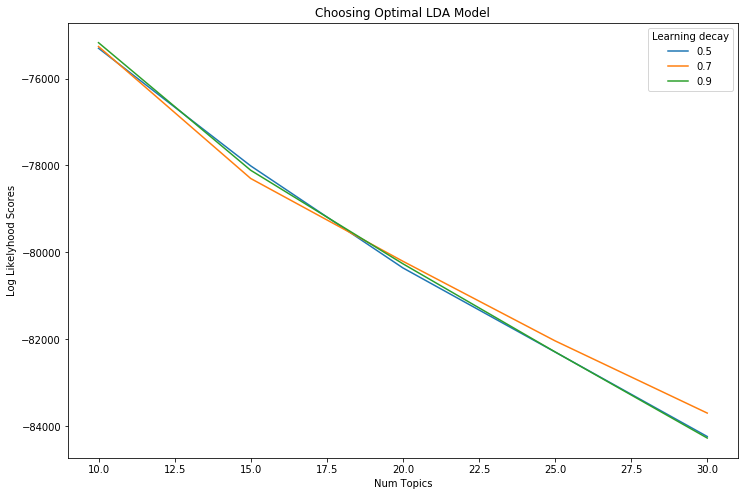

In [42]:
# Get Log Likelyhoods from Grid Search Output
n_topics = [10, 15, 20, 25, 30]
log_likelyhoods_5 = [round(model.cv_results_['mean_test_score'][index]) for index, gscore in enumerate(model.cv_results_['params']) if gscore['learning_decay']==0.5]
log_likelyhoods_7 = [round(model.cv_results_['mean_test_score'][index]) for index, gscore in enumerate(model.cv_results_['params']) if gscore['learning_decay']==0.7]
log_likelyhoods_9 = [round(model.cv_results_['mean_test_score'][index]) for index, gscore in enumerate(model.cv_results_['params']) if gscore['learning_decay']==0.9]

# Show graph
plt.figure(figsize=(12, 8))
plt.plot(n_topics, log_likelyhoods_5, label='0.5')
plt.plot(n_topics, log_likelyhoods_7, label='0.7')
plt.plot(n_topics, log_likelyhoods_9, label='0.9')
plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Log Likelyhood Scores")
plt.legend(title='Learning decay', loc='best')
plt.show()

In [ ]:
## See the dominant topic in each document

In [44]:
# Create Document - Topic Matrix
lda_output = best_lda_model.transform(data_vectorized)

# column names
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)]

# index names
docnames = ["Doc" + str(i) for i in range(len(data))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,dominant_topic
Doc0,0.000000,0.000000,0.000000,0.730000,0.000000,0.180000,0.000000,0.000000,0.070000,0.000000,3
Doc1,0.420000,0.020000,0.020000,0.450000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,3
Doc2,0.020000,0.850000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,1
Doc3,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.270000,0.010000,0.680000,9
Doc4,0.610000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.310000,0.010000,0.010000,0
Doc5,0.010000,0.300000,0.010000,0.620000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,3
Doc6,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.850000,0.020000,0.020000,7
Doc7,0.500000,0.010000,0.010000,0.410000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0
Doc8,0.010000,0.010000,0.010000,0.440000,0.010000,0.010000,0.010000,0.490000,0.010000,0.010000,7
Doc9,0.010000,0.010000,0.010000,0.010000,0.670000,0.010000,0.010000,0.010000,0.010000,0.290000,4


## Review topics distributions across documents

In [45]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,3,896
1,5,549
2,0,516
3,8,512
4,9,469
5,4,460
6,6,371
7,1,369
8,7,297
9,2,232


## Review with PyLDAVis

In [48]:
import pyLDAvis
from pyLDAvis import sklearn
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(best_lda_model, data_vectorized, vectorizer, mds='tsne')
panel

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
3      32.420952   8.115230       1        1  16.219633
8       0.648955  71.707100       2        1  10.842170
4      71.019684   9.971006       3        1  10.694115
9       3.785981  33.185135       4        1  10.409988
5     -42.666500  -9.222070       5        1  10.014537
1      -3.621689 -43.526516       6        1   9.604036
0      -3.632402  -4.171708       7        1   9.132811
6     -36.584400  35.804413       8        1   8.586008
7      44.391380  50.615383       9        1   8.248239
2      40.235809 -31.591665      10        1   6.248463, topic_info=          Term         Freq        Total Category  logprob  loglift
887    twitter  1563.000000  1563.000000  Default  30.0000  30.0000
620        pic   863.000000   863.000000  Default  29.0000  29.0000
98        care   312.000000   312.000000  Default  28.0000  28.0000
396     health   338.000000   338.000000  Default  27.0000  27.0000
133        com  2179.000000  2179.000000  Default  26.0000  26.0000
..         ...          ...          ...      ...      ...      ...
140  community    28.263966   207.558202  Topic10  -4.7355   0.7790
647  president    30.409823   480.896061  Topic10  -4.6623   0.0119
279     ensure    25.017985   205.056583  Topic10  -4.8575   0.6691
35    american    25.349087   294.511900  Topic10  -4.8443   0.3203
464       just    25.141923   274.032211  Topic10  -4.8525   0.3841

[595 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
0         4  0.886516  abandon
0         7  0.068194  abandon
5         8  0.187104      aca
5         9  0.748416      aca
6         3  0.962349   accept
...     ...       ...      ...
958       3  0.631681    young
958       7  0.090240    young
958       8  0.112800    young
959       8  0.873106      zip
959       9  0.067162      zip

[1425 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 9, 5, 10, 6, 2, 1, 7, 8, 3])

## Top 15 words in each topic

In [49]:
# Show top n keywords for each topic
def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=15)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,com,twitter,middle,class,pic,campaign,time,country,http,come,join,great,thank,rebuild,today
Topic 1,gun,com,violence,end,https,time,pay,twitter,epidemic,pass,worker,reform,status,need,crisis
Topic 2,policy,foreign,trump,support,business,need,faith,value,candidate,demdebate,worker,help,small,family,election
Topic 3,com,twitter,pic,https,help,need,status,day,make,climate,president,time,chip,beat,trump
Topic 4,year,nation,climate,change,family,ago,today,child,life,love,people,word,country,heart,address
Topic 5,com,make,day,watch,http,tune,today,tonight,vote,join,talk,twitter,live,head,stage
Topic 6,plan,health,care,tax,cut,com,make,ban,work,weapon,education,http,student,high,wealthy
Topic 7,care,health,com,twitter,protect,soul,nation,need,battle,affordable,hate,pic,fight,safe,ensure
Topic 8,com,american,people,twitter,president,https,status,vote,nation,make,need,right,say,trump,election
Topic 9,work,woman,fight,right,make,today,stand,proud,job,country,deserve,dignity,good,day,law


## Predict topics for a given piece of text

In [52]:
# Define function to predict topic for a given text document.
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def predict_topic(text, nlp=nlp):
    global sent_to_words
    global lemmatization

    # Step 1: Clean with simple_preprocess
    mytext_2 = list(sent_to_words(text))

    # Step 2: Lemmatize
    mytext_3 = lemmatization(mytext_2, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

    # Step 3: Vectorize transform
    mytext_4 = vectorizer.transform(mytext_3)

    # Step 4: LDA Transform
    topic_probability_scores = best_lda_model.transform(mytext_4)
    topic = df_topic_keywords.iloc[np.argmax(topic_probability_scores), :].values.tolist()
    return topic, topic_probability_scores

# Predict the topic
mytext = ["Climate change is an issue of our times"]
topic, prob_scores = predict_topic(text = mytext)
print(topic)

['year', 'nation', 'climate', 'change', 'family', 'ago', 'today', 'child', 'life', 'love', 'people', 'word', 'country', 'heart', 'address']
